Analizowanym przez nas zbiorem danych jest zbiór 'car evaluation'. Zawiera on aż 1728 alternatyw przypisanych do 4 możliwych klas decyzyjnych. Wartości tych klas (liczby od 1 do 4) przypisują kolejnym wierszom reprezentującym różne modele samochodów odpowiednią jakość danego auta (odpowiednio nieakceptowalny, akceptowalny, dobry, bardzo dobry). Odpowiednie przypadki reprezentowane są na podstawie wartości na 6 atrybutach warunkowych, którym można przypisać następujące znaczenie: cena zakupu (kryterium typu koszt), koszt utrzymania (koszt), liczba drzwi (zysk), pojemność - liczba osób (zysk), wielkość bagażnika (zysk), bezpieczeństwo (zysk). Wartości porządkowe tych atrybutów zostały przetransformowane do wartości numerycznych w skali od 0 do 1 w zależności od charakteru danego kryterium. Dla tego problemu wytrenowane zostaną 3 modele:
* interpretowalny model rankSVM
* interpretowalny model ANN-Ch-Constr.
* złożony model sieci neuronowej zawierający kilka warstw ukrytych.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from anchor import utils
from anchor import anchor_tabular
import torch
import torch.nn as nn
import torch.nn.functional as F

from helpers import *

In [108]:
def TransformRowDiff(d):
    a = np.lib.stride_tricks.as_strided(
        d,
        (d.shape[0], d.shape[0], d.shape[1]),
        (d.itemsize * d.shape[1], 0, d.itemsize),
    )
    a = a.reshape(-1, d.shape[1])
    
    b = np.lib.stride_tricks.as_strided(
        d,
        (d.shape[0], d.shape[0], d.shape[1]),
        (0, d.itemsize * d.shape[1], d.itemsize),
    )
    b = b.reshape(-1, d.shape[1])
    return a - b

In [2]:
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
data.columns = ['buying', 'maintenance', 'doors_number', 'persons_number', 'lug_boot', 'safety', 'decision']
print(data[data['decision'] == 1].shape[0])
print(data[data['decision'] != 1].shape[0])

1210
518


Ze względu na charakter rozpatrywanego problemu oraz jego uogólnienia, binaryzujemy wartości atrybutu decyzyjnego. Przedstawiony wyżej rozkład wartości sugeruje, że w zbiorze znajduje się zdecydowanie więcej wartości 1 tego atrybutu (unacceptable) niż pozostałych. W tym kontekście od teraz wartość 0 atrybutu decyzyjnego będzie sugerowała, aby danego auta nie kupywać, wartość 1 natomiast będzie oznaczała, że dane auto spełnia kryteria decydenta odnośnie do jego zakupu.

## Model rankSVM

In [110]:
target_map = {1: 0, 2: 1, 3: 1, 4: 1}
criteria_name = 'decision'
data[criteria_name] = data[criteria_name].apply(lambda x: target_map[x])
data = data.drop_duplicates()
data_input = data.drop(columns=[criteria_name])
data_target = data[criteria_name]

data_input = data_input.values

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

X_train = TransformRowDiff(X_train)
X_test = TransformRowDiff(X_test)
y_train = TransformRowDiff(y_train.reshape(-1, 1))[:, 0]
y_test = TransformRowDiff(y_test.reshape(-1, 1))[:, 0]

X_train = X_train[y_train != 0]
y_train = y_train[y_train != 0]


X_test = X_test[y_test != 0]
y_test = y_test[y_test != 0]

In [111]:
np.unique(y_train)

array([-1,  1], dtype=int64)

In [33]:
model = svm.LinearSVC()
model.fit(X_train,y_train)

LinearSVC()

In [35]:
print(model)

LinearSVC()


In [66]:
y_pred = model.predict(X_train)
out = np.dot(X_train, model.coef_.T)
print("Accuracy train:\t%.2f%%" % (accuracy_score(y_train, y_pred) * 100.0))
print("F1 train:\t%.2f%%" % (f1_score(y_train, y_pred) * 100.0))
print("AUC train: \t%.2f%%" % (roc_auc_score(y_train, out) * 100.0))
print()

y_pred = model.predict(X_test)
out = np.dot(X_test, model.coef_.T)
print("Accuracy test:\t%.2f%%" % (accuracy_score(y_test, y_pred) * 100.0))
print("F1 test:\t%.2f%%" % (f1_score(y_test, y_pred) * 100.0))
print("AUC test: \t%.2f%%" % (roc_auc_score(y_test, out) * 100.0))

Accuracy train:	93.59%
F1 train:	93.59%
AUC train: 	98.54%

Accuracy test:	94.45%
F1 test:	94.45%
AUC test: 	98.93%


In [86]:
print(X_train)
print(y_train)

[[-0.666667  0.333333  0.       -1.        0.        0.5     ]
 [-1.        0.        0.333334 -0.5       0.        0.      ]
 [ 0.       -0.333334  0.333334 -1.        0.5       0.      ]
 ...
 [ 0.       -0.333333  0.333334 -0.5       0.        0.      ]
 [ 0.       -0.333333  0.666667 -0.5      -0.5       0.5     ]
 [ 0.333334  0.        0.333334 -0.5       0.        0.5     ]]
[-1 -1 -1 ... -1 -1 -1]


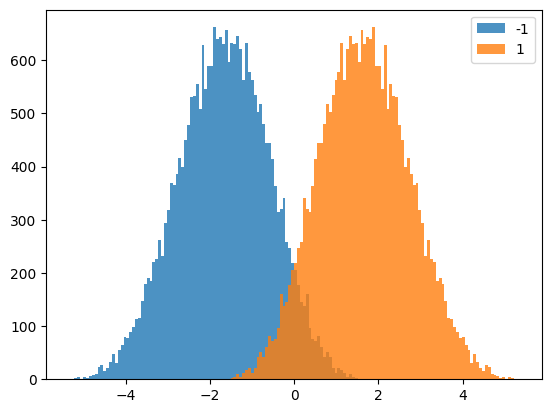

In [85]:
plt.hist(out[y_test==-1], alpha=0.8, bins=100, label="-1")
plt.hist(out[y_test==1], alpha=0.8, bins=100, label="1")
plt.legend()
plt.show()

In [68]:
w = model.coef_[0]
print(f'coef {w}')
b = model.intercept_[0]
print(f'intercept {b}')

coef [-0.83403362 -0.79325412  0.24928367  1.46162385  0.55637748  1.72315606]
intercept 2.4283669132496317e-07


In [69]:
def plotDensity(X_train, y_train, c_1, c_2, samples=10000):
    axes = sns.jointplot(
        x=X_train[:samples, c_1],
        y=X_train[:samples, c_2],
        hue=y_train[:samples],
        kind="kde",
        palette=["green", "red"],
        fill=True,
        alpha=0.5,
    )
    x_points = np.linspace(-1, 1)
    y_points = -(w[c_1] / w[c_2]) * x_points - b / w[c_2]
    x_points = x_points[np.logical_and(y_points < 1, y_points > -1)]
    y_points = y_points[np.logical_and(y_points < 1, y_points > -1)]
    axes.ax_joint.plot(x_points, y_points, c="b")
    axes.ax_joint.set_xlabel(f"kryterium: {c_1}")
    axes.ax_joint.set_ylabel(f"kryterium: {c_2}")

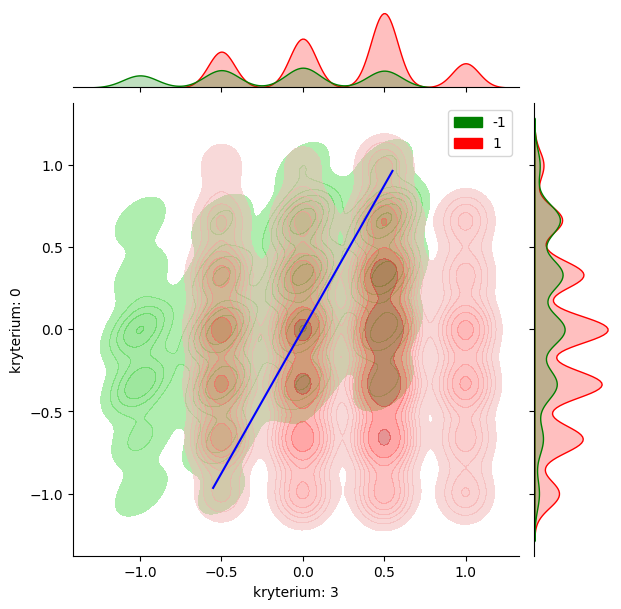

In [83]:
c_1 = 3
c_2 = 2
plotDensity(X_train, y_train, c_1, c_2, samples=10000)

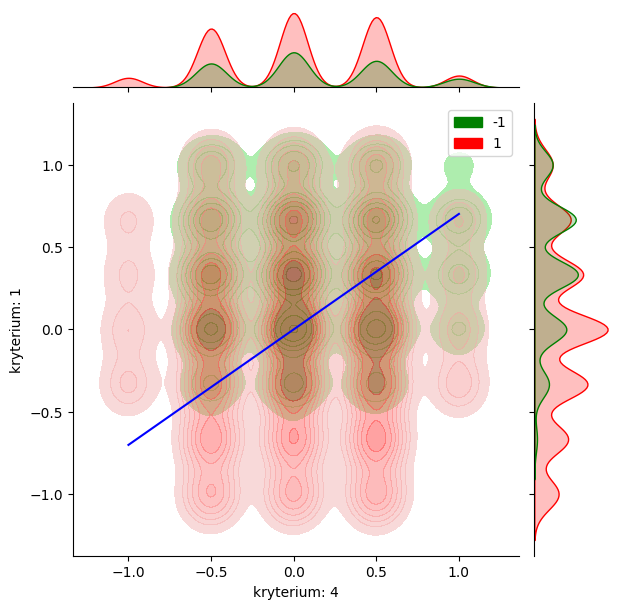

In [79]:
c_1 = 4
c_2 = 1
plotDensity(X_train, y_train, c_1, c_2, samples=10000)

Na podstawie uzyskanych parametrów można stwierdzić, że użytkownicy przy ocenie samochodu pod kątem ewentualnego zakupu, biorą pod uwagę przede wszystkim jego bezpieczeństwo. Również dość istotnym parametrem jest kwestia maksymalnej liczby osób, które dany pojazd może pomieścić. Koszty utrzymania oraz zakupu danego pojazdu także są dość istotne. Najmniej istotnym kryterium jest liczba drzwi, w które dany samochód jest wyposażony. Decydujący wpływ zdaje się mieć kryterium bezpieczeństwa - żaden z decydentów nie będzie skłonny do zakupu auta, które jest skrajnie niebezpieczne. Jednak określenie "skrajny" jest w tym kontekście najistotniejsze - każde kryterium w różny sposób wpływa na ostateczną decyzję i żadnego z nich nie można w tym przypadku wykluczyć. Jak można zauważyć na powyższych wykresach poszczególne kryteria nie są separowalne liniowo w 2-wymiarowej przestrzeni - nie sposób odnaleźć progi decyzyjne. Istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji - żadne z kryterium nie jest w pełni decydujące.

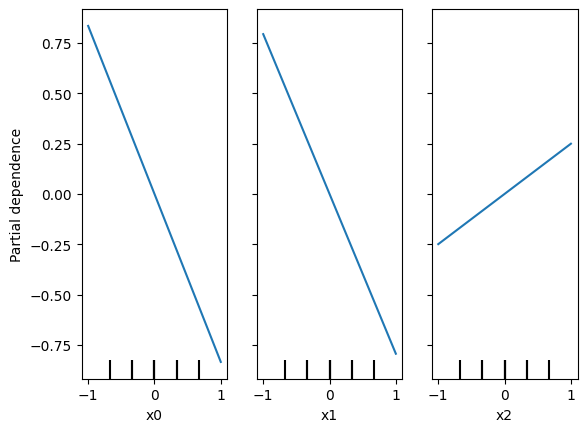

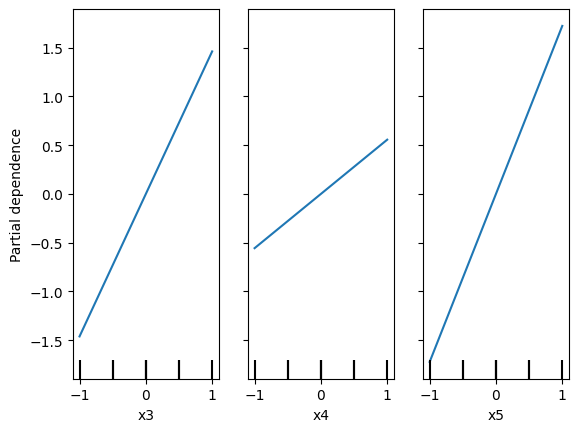

In [91]:
features_1 = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features_1)
features_2 = [3, 4, 5]
PartialDependenceDisplay.from_estimator(model, X_train, features_2)

In [94]:
permutation_importance_result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
print(permutation_importance_result.importances_mean)
print(permutation_importance_result.importances_std)

[0.04060795 0.03571511 0.00312594 0.14860745 0.02013721 0.22667183]
[0.00012576 0.00021608 0.00010712 0.00037768 0.00014086 0.000459  ]


Wyniki uzyskane z powyższych technik interpretacji modelu potwierdzają wykonaną w poprzednim punkcie analizę.

In [127]:
chosen_variants_input = np.array([X_train[256], X_train[367], X_train[1279]])
chosen_variants_target = np.array([y_train[256], y_train[367], y_train[1279]])
print(chosen_variants_input)
print(chosen_variants_target)

[[-0.333333 -0.333334  0.666667 -1.       -0.5       0.      ]
 [-1.        0.333333  0.333334 -1.       -0.5       0.      ]
 [ 0.666667 -0.666667  0.666667  0.        0.5      -0.5     ]]
[-1 -1  1]


Ze względu na specyfikę analizowanej metody trudno jest analitycznie wyznaczyć kluczową zmianę. Dla każdego wariantu obliczana jest różnica pomiędzy wszystkimi wariantami z przeciwnej klasy. Opierając się na tych różnicach stwierdzam, że gdy jest ona dodatnia dla atrybutu 'safety', powyższe warianty 1 i 2 będą należały do klasy 1.

In [129]:
chosen_variants_input[0][5], chosen_variants_input[1][5] = 1, 1
y_probe = model.predict(chosen_variants_input)
print(y_probe[0], y_probe[1]) 

1 1


Uzyskane wyniki zgadzają się z przewidywaniami teoretycznymi.

In [113]:
explainer = anchor_tabular.AnchorTabularExplainer(
    [0, 1],
    ['buying', 'maintenance', 'doors_number', 'persons_number', 'lug_boot', 'safety'],
    X_train)

In [126]:
index = 0
print(X_test[index])
np.random.seed(1)
print('Prediction: ', explainer.class_names[model.predict(X_test[index].reshape(1, -1))[0]])
exp = explainer.explain_instance(X_test[index], model.predict, threshold=0.95)

print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

[ 0.        0.666667 -0.666667 -0.5      -0.5      -1.      ]
Prediction:  1
Anchor: safety <= -0.50 AND persons_number <= -0.50
Precision: 1.00
Coverage: 0.18


Kluczowe dla powyższego wyjaśnienia okazały się atrybuty 'safety' i dość nieoczekiwanie 'persons_number'.

## Model ANN-Ch-Constr.

In [3]:
class LinearGreaterThanZero(nn.Linear):
    def __init__(self, in_features, bias=False, min_w=0.0000001):
        super().__init__(in_features, 1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w, 1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def w(self):
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), self.bias)

In [4]:
class LinearInteraction(nn.Linear):
    def __init__(self, in_features, criterion_layer):
        super().__init__(((in_features - 1) * in_features) // 2, 1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def w(self):
        with torch.no_grad():
            w_i = 0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i + 1, self.in_features):
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, i]
                    )
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, j]
                    )
                    w_i += 1
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), None)

In [6]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold=None, requires_grad=True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.5), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x):
        return x - self.threshold

In [7]:
class ChoquetConstrained(nn.Module):
    def __init__(self, criteria_nr, **kwargs):
        super().__init__()
        self.criteria_nr = criteria_nr
        self.criteria_layer = LinearGreaterThanZero(criteria_nr)
        self.interaction_layer = LinearInteraction(criteria_nr, self.criteria_layer)
        self.thresholdLayer = ThresholdLayer()

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[:, 0, :]
        x_wi = self.criteria_layer(x[:, : self.criteria_nr])
        x_wij = self.interaction_layer(x[:, self.criteria_nr :])
        weight_sum = self.criteria_layer.w().sum() + self.interaction_layer.w().sum()
        score = (x_wi + x_wij) / (weight_sum)
        return self.thresholdLayer(score)

In [8]:
def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [8]:
print(data.iloc[:, 6])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1723    3.0
1724    4.0
1725    1.0
1726    3.0
1727    4.0
Name: decision, Length: 1728, dtype: float64


In [39]:
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
target_map = {1: 0, 2: 1, 3: 1, 4: 1}
criteria_nr = 6
data_input = data.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)
data_target = data.iloc[:, criteria_nr].apply(lambda x: target_map[x])

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

In [40]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [23]:
PATH = "choquet.pt"

In [41]:
model = ChoquetConstrained(criteria_nr)

In [42]:
acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


In [43]:
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc* 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

Accuracy train:	69.68%
AUC train: 	69.68%
F1 train: 	44.94%

Accuracy test:	69.68%
AUC test: 	70.44%
F1 test: 	51.23%


In [44]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [45]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

In [46]:
print("Criteria weights:")
print(weights)
print()
print("Criteria interactions:")
print(interactions)

Criteria weights:
[0.0787916  0.04678355 0.0500437  0.06793891 0.08700712 0.01685331]

Criteria interactions:
[[0.         0.03381142 0.01934491 0.02248647 0.03662796 0.07224939]
 [0.03381142 0.         0.06187785 0.04378799 0.06657804 0.05247755]
 [0.01934491 0.06187785 0.         0.03296104 0.02529496 0.06365646]
 [0.02248647 0.04378799 0.03296104 0.         0.05443588 0.04676699]
 [0.03662796 0.06657804 0.02529496 0.05443588 0.         0.02022497]
 [0.07224939 0.05247755 0.06365646 0.04676699 0.02022497 0.        ]]


In [47]:
shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley)

Importance of criterina (Shapley value):
[0.17105168 0.17604997 0.15161132 0.1681581  0.18858802 0.14454099]


Na podstawie uzyskanych parametrów można stwierdzić, że użytkownicy przy ocenie samochodu pod kątem ewentualnego zakupu, biorą pod uwagę przede wszystkim jego bezpieczeństwo. Również dość istotnym parametrem jest kwestia maksymalnej liczby osób, które dany pojazd może pomieścić. Koszty utrzymania oraz zakupu danego pojazdu także są dość istotne. Najmniej istotnym kryterium jest liczba drzwi, w które dany samochód jest wyposażony. Decydujący wpływ zdaje się mieć kryterium bezpieczeństwa - żaden z decydentów nie będzie skłonny do zakupu auta, które jest skrajnie niebezpieczne. Jednak określenie "skrajny" jest w tym kontekście najistotniejsze - każde kryterium w różny sposób wpływa na ostateczną decyzję i żadnego z nich nie można w tym przypadku wykluczyć. Jak można zauważyć na powyższych wykresach poszczególne kryteria nie są separowalne liniowo w 2-wymiarowej przestrzeni - nie sposób odnaleźć progi decyzyjne. Istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji - żadne z kryterium nie jest w pełni decydujące.

In [51]:
features_1 = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features_1)
features_2 = [3, 4, 5]
PartialDependenceDisplay.from_estimator(model, X_train, features_2)

TypeError: ChoquetConstrained(
  (criteria_layer): LinearGreaterThanZero(in_features=6, out_features=1, bias=False)
  (interaction_layer): LinearInteraction(
    in_features=6, out_features=1, bias=False
    (criterion_layer): LinearGreaterThanZero(in_features=6, out_features=1, bias=False)
  )
  (thresholdLayer): ThresholdLayer()
) is not an estimator instance.